In [1]:
# pip install clean-text
# pip install unidecode
# pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cleantext import clean
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense

In [3]:
df_train = pd.read_csv('./dataset/twitter_training.csv', header=None)
df_valid = pd.read_csv('./dataset/twitter_validation.csv', header=None)

In [4]:
df_train.columns = ['ID', 'Name', 'Label', 'Content']
df_valid.columns = ['ID', 'Name', 'Label', 'Content']
df_train

,ID,Name,Label,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [7]:
missing_values_train = df_train.isnull().sum()
missing_values_percent_train = (df_train.isnull().sum()) / (len(df_train))
duplicated_values_train = df_train.duplicated().sum()
duplicated_values_percent_train = (df_train.duplicated().sum() / (len(df_train)))

missing_values_valid = df_valid.isnull().sum()
missing_values_percent_valid = (df_valid.isnull().sum()) / (len(df_valid))
duplicated_values_valid = df_valid.duplicated().sum()
duplicated_values_percent_valid = (df_valid.duplicated().sum() / (len(df_valid)))

explain_df = pd.DataFrame({'Missed_values_train': missing_values_train, 'Missed_values_%_train':missing_values_percent_train, 
                          'Duplicated_values_train': duplicated_values_train, 'Duplicated_values_%_train': duplicated_values_percent_train,
                          'Missed_values_valid': missing_values_valid, 'Missed_values_%_valid':missing_values_percent_valid, 
                          'Duplicated_values_valid': duplicated_values_valid, 'Duplicated_values_%_valid': duplicated_values_percent_valid})

explain_df

,Missed_values_train,Missed_values_%_train,Duplicated_values_train,Duplicated_values_%_train,Missed_values_valid,Missed_values_%_valid,Duplicated_values_valid,Duplicated_values_%_valid
ID,0,0.000000,2700,0.036153,0,0.0,0,0.0
Name,0,0.000000,2700,0.036153,0,0.0,0,0.0
Label,0,0.000000,2700,0.036153,0,0.0,0,0.0
Content,686,0.009186,2700,0.036153,0,0.0,0,0.0


In [8]:
df_train.dropna(inplace=True)
df_train.drop_duplicates(inplace=True)

In [56]:
df_train['Label'] = df_train['Label'].replace('Irrelevant', 'Neutral')
df_valid['Label'] = df_valid['Label'].replace('Irrelevant', 'Neutral')

In [57]:
df_train['Label'].value_counts()

Label
Neutral     31308
Negative    22542
Positive    20832
Name: count, dtype: int64

In [58]:
train_sentences = df_train['Content'].to_numpy()
valid_sentences = df_valid['Content'].to_numpy()

label_mapping = {'Positive':0, 'Negative':1, 'Neutral':2}
train_label = df_train['Label'].map(label_mapping)
valid_label = df_valid['Label'].map(label_mapping)

In [59]:
valid_sentences[:10]

array(['I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣',
       "BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine…",
       '@Microsoft Why do I pay for WORD when it functions so poorly on my @SamsungUS Chromebook? 🙄',
       "CSGO matchmaking is so full of closet hacking, it's a truly awful game.",
       'Now the President is slapping Americans in the face that he really did commit an unlawful act after his  acquittal! From Discover on Google vanityfair.com/news/2020/02/t…',
       'Hi @EAHelp I’ve had Madeleine McCann in my cellar for the past 13 years and the little sneaky thing just escaped whilst I was loading up some fifa points, she took my card and I’m having to use my paypal account but it isn’t working, can you help me reso

In [60]:
remove_emoji_train_sentences = []
remove_emoji_valid_sentences = []

for sentence in train_sentences:
    remove_emoji_train_sentences.append(clean(sentence, no_emoji=True))

for sentence in valid_sentences:
    remove_emoji_valid_sentences.append(clean(sentence, no_emoji=True))

In [61]:
remove_emoji_valid_sentences[:10]

["i mentioned on facebook that i was struggling for motivation to go for a run the other day, which has been translated by tom's great auntie as 'hayley can't get out of bed' and told to his grandma, who now thinks i'm a lazy, terrible person",
 "bbc news - amazon boss jeff bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine...",
 '@microsoft why do i pay for word when it functions so poorly on my @samsungus chromebook?',
 "csgo matchmaking is so full of closet hacking, it's a truly awful game.",
 'now the president is slapping americans in the face that he really did commit an unlawful act after his acquittal! from discover on google vanityfair.com/news/2020/02/t...',
 "hi @eahelp i've had madeleine mccann in my cellar for the past 13 years and the little sneaky thing just escaped whilst i was loading up some fifa points, she took my card and i'm having to use my paypal account but it isn't working, can you help me resolve it please?",
 'thank you @eamadde

In [62]:
lb = LabelBinarizer()

train_label = lb.fit_transform(train_label)
valid_label = lb.transform(valid_label)

In [63]:
print(train_label[0])
print(valid_label[0])

[1 0 0]
[0 0 1]


In [64]:
vocabulary_size = 10000

embedding_dim = 64

max_length_sentence = 150

In [65]:
tokenizer = Tokenizer(num_words=vocabulary_size, oov_token='OOV', lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

tokenizer.fit_on_texts(remove_emoji_train_sentences)

In [66]:
print(list(tokenizer.word_index.items())[:50])

[('OOV', 1), ('the', 2), ('i', 3), ('to', 4), ('and', 5), ('a', 6), ('of', 7), ('is', 8), ('in', 9), ('for', 10), ('this', 11), ('it', 12), ('you', 13), ('on', 14), ('my', 15), ('that', 16), ('com', 17), ('with', 18), ('game', 19), ('so', 20), ('be', 21), ('me', 22), ('have', 23), ('just', 24), ('but', 25), ('not', 26), ('are', 27), ('all', 28), ('at', 29), ('was', 30), ('like', 31), ('out', 32), ('2', 33), ('from', 34), ('your', 35), ("i'm", 36), ('pic', 37), ('twitter', 38), ('now', 39), ('we', 40), ('get', 41), ('as', 42), ('they', 43), ('if', 44), ('has', 45), ('one', 46), ('t', 47), ('do', 48), ('good', 49), ('about', 50)]


In [67]:
remove_emoji_train_sentences = tokenizer.texts_to_sequences(remove_emoji_train_sentences)

In [68]:
remove_emoji_train_sentences[0]

[307, 176, 14, 142, 5, 3, 55, 1760, 13, 28]

In [69]:
padding_train_sentences = pad_sequences(remove_emoji_train_sentences, maxlen= max_length_sentence, truncating= 'post', padding= 'post')

padding_train_sentences

array([[ 307,  176,   14, ...,    0,    0,    0],
       [   3,  123,  405, ...,    0,    0,    0],
       [ 307,  176,   14, ...,    0,    0,    0],
       ...,
       [  24, 1962,    2, ...,    0,    0,    0],
       [  24, 1962,  743, ...,    0,    0,    0],
       [  24,   31,    2, ...,    0,    0,    0]])

In [70]:
padding_train_sentences.shape

(74682, 150)

In [71]:
remove_emoji_valid_sentences = tokenizer.texts_to_sequences(remove_emoji_valid_sentences)
padding_valid_sentences = pad_sequences(remove_emoji_valid_sentences, maxlen= max_length_sentence, truncating= 'post', padding= 'post')

In [72]:
padding_valid_sentences.shape

(1000, 150)

In [74]:
inputs = Input(shape=(max_length_sentence,))  
x = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)(inputs)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 150, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │        96,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 736,043 (2.81 MB)

 Trainable params: 736,043 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
print('Build model')

history = model.fit(padding_train_sentences, train_label, epochs=20, validation_data=(padding_valid_sentences, valid_label))

print('Success')

Build model
Epoch 1/20
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5933 - loss: 0.8446 - val_accuracy: 0.9530 - val_loss: 0.1716
Epoch 2/20
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9051 - loss: 0.2546 - val_accuracy: 0.9760 - val_loss: 0.0994
Epoch 3/20
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9450 - loss: 0.1404 - val_accuracy: 0.9660 - val_loss: 0.0922
Epoch 4/20
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9550 - loss: 0.1094 - val_accuracy: 0.9760 - val_loss: 0.0892
Epoch 5/20
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9619 - loss: 0.0907 - val_accuracy: 0.9790 - val_loss: 0.0808
Epoch 6/20
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9648 - loss: 0.0823 - val_accuracy: 0.9700 - val_loss: 0.1003
Epoch 7/20
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9652 - loss: 0.0782 - val_accuracy: 0.9810 - val_loss: 0.0870
Epoch 8/20
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.96

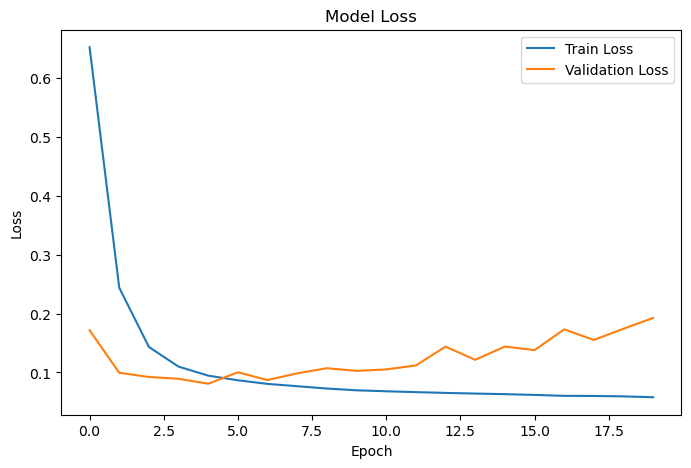

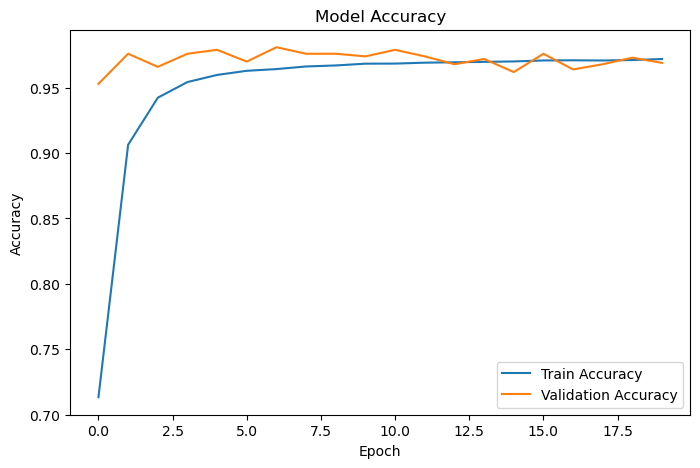

In [79]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(history.history.get('loss', []), label='Train Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()